<div class="alert alert-block alert-info">
    <b><p style="font-size: XX-large">Logistic Regression:</p></b> </div>  
    <b><p style="font-size: X-large">Using Centipawn to Predict Win Probability in Chess</p></b> </div> 
Joseph Nelson Farrell & James Parkington
  
DS 5020: Linear Algebra & Probability for DS
    
Northeastern University
    
Westin Viles, Phd.
    
08/01/2023

<div class="alert alert-block alert-info">
    <b><p style="font-size: X-large">Import Packages</p></b> </div> 

In [102]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

<div class="alert alert-block alert-info">
    <b><p style="font-size: X-large">Function to read in data</p></b> </div>

In [103]:
def combine_folders(base_directory: str)-> pd.DataFrame:
    '''
        Function: combine_folders
        Parameters: 1 string; the path directory to the folder containing the folders to be combined
        Returns: 1 pd.DataFrame

        This function will take all contents from all the folder within a folder and combine them all 
        in a single dataframe
    '''

    # list the subdirectories (folders) within the base directory
    subdirectories = [subdir for subdir in os.listdir(base_directory) if os.path.isdir(os.path.join(base_directory, subdir))]

    # initialize an empty list to store DataFrames
    dataframes = []

    # loop through the subdirectories
    for subdir in subdirectories:
        subdir_path = os.path.join(base_directory, subdir)
        
        # list the contents of the current subdirectory
        subdirectory_contents = os.listdir(subdir_path)
        
        # read each Parquet file into a DataFrame and append to the list
        for file_name in subdirectory_contents:
            file_path = os.path.join(subdir_path, file_name)
            if file_name.endswith('.parquet'):
                df = pd.read_parquet(file_path)
                dataframes.append(df)

    # concatenate the list of DataFrames into a single DataFrame
    boards_df = pd.concat(dataframes, ignore_index=True)
    return boards_df

<div class="alert alert-block alert-info">
    <b><p style="font-size: X-large">Function to generate dataframe</p></b> </div>

In [104]:
def extract_eval_and_outcome(df: pd.DataFrame) -> pd.DataFrame:
    '''
        Function: extract_eval_and_outcome
        Parameters: 1 pd.DataFrame
        Returns: 1 pd.DataFrame

        This function extract the outcome from the game and the centipawn evaluation at the end
        of the game. It will return a dataframe with 2 columns
    '''
    # filter for games longer than 15 moves
    df = df.loc[df['ply'] > 15]

    # extract outcome
    df['win_condition'] = df['pgn'].str.extract(r'\[Result "([^"]+)"\]')

    # filter for games that do not end in a draw
    df = df[(df['win_condition'].str.contains('0-')) | (df['win_condition'].str.contains('1-'))]

    # recode outcome as an integer, 1 for white win, 0 for black win
    df['winner'] = df['win_condition'].map(lambda x: 1 if x == '1-0' else 0)

    # generate a list of unique games
    unique_games = df['game_id'].unique()

    # initialize a new df
    new_df = pd.DataFrame()

    # iterate over unique games selecting outcome and ending centipawn eval
    for game in unique_games:
        x = df[(df['game_id'] == game)]
        max_ply = x['ply'].max()
        new_col = x.loc[x['ply'] == max_ply][['centipawn_evaluation', 'winner']]
        new_df = pd.concat([new_df, new_col], axis = 0)

    # return new df
    return new_df


<div class="alert alert-block alert-info">
    <b><p style="font-size: X-large">Read in Data & Generate Dataframe</p></b> </div>

In [105]:
# define the path to the directory containing your folders
base_directory = "/Users/nelsonfarrell/Documents/Northeastern/5020/final_project/Project-Gambit/Games/Storage"

# invoke combine folders()
boards_df = combine_folders(base_directory)

# invoke extract_eval
new_df = extract_eval_and_outcome(boards_df)

/var/folders/jw/62ly49f15zj22rm_89qjsv940000gn/T/ipykernel_72286/1957700597.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['win_condition'] = df['pgn'].str.extract(r'\[Result "([^"]+)"\]')


<div class="alert alert-block alert-info">
    <b><p style="font-size: X-large">Regression Functions</p></b> </div>

In [106]:
def sigmoid(beta: np.ndarray, x: np.ndarray) -> float:
    '''
        Function: sigmoid
        Parameters: 2 np.arrays
        Returns: 1 float

        The function takes two arrays, the beta array and array predictor variables. It returns the 
        probability P(Y = y|X = x)
    '''
    # compute logistitc fuction
    p_y = 1/(1+np.exp(-(beta[0] + beta[1]*x)))

    # return p_y
    return p_y 

def gradient(beta: np.ndarray, x_train: np.ndarray, y_train: np.ndarray) -> np.ndarray:
    '''
        Function: gradient
        Parameters: 3 np.array; beta vector and the training vectors
        Returns: 1 np.array

        This function will return the gradient, i.e., the two partial derivatives of sigmoid() evaluated
        at the current value of the beta vector. The derivatives have been hard coded into the function.
    '''
    # invoke sigmoid function
    pi = sigmoid(beta, x_train)

    # compute gradient
    gradient = np.array([np.mean(pi-y_train),np.mean((pi-y_train)*x_train)])

    # return gradient
    return gradient

def hessian(beta: np.ndarray, x_train: np.ndarray) -> np.ndarray:
    '''
        Function: hessian
        Parameters: 2 np.array; beta vector and the training vector
        Returns: 1 np.array

        This function will return the hessian matrix, i.e., the two second partial derivatives and the two mixed second
        partial derivatives of sigmoid() evaluated at the current value of the beta vector. The derivatives have been 
        hard coded into the function.
    '''
     # invoke sigmoid function
    pi = sigmoid(beta, x_train)

    # compute hessian
    hessian = np.array([[np.mean(pi*(1-pi)),np.mean(pi*(1-pi)*x_train)],[np.mean(pi*(1-pi)*x_train),np.mean(pi*(1-pi)*x_train*x_train)]])
    return hessian

def newton_method(x_train: np.ndarray, y_train: np.ndarray, beta: np.ndarray = None, eps: float = 1e-3, ) -> np.ndarray:
    '''
        Function: newton_method
        Parameters: 3 np.arrays, 1 optional
        Returns: 1 np.array

        This function contains an implementation of Newtons's Method for convex optimazation for a 
        multivariate function. This function uses gradient() and hessian() functions.

        Required parameters are the training vectors, the beta vector and the tollerance are optional.
    '''
    # if beta is not provided initialize a 0 vector and assign to beta
    if beta is None:
        beta = np.array([0,0])
    
    # assign beta_old to equal beta
    beta_old = beta

    # this implements Newton's method
    beta = beta - np.matmul(np.linalg.inv(hessian(beta, x_train)), gradient(beta, x_train, y_train))

    # this will check if difference between beta_old and beta is within tollerance
    if np.max(np.abs(beta-beta_old))<eps:

        # if yes, return beta
        return beta
    else:

        # if no, recursive call to newton_method
        return newton_method(x_train, y_train, beta)

<div class="alert alert-block alert-info">
    <b><p style="font-size: X-large">Execute Regression </p></b> </div>

This block contains to invocation of the regresssion functions and the implentation of the model

In [107]:
# generate two vectors to test the model after training
x_test = new_df['centipawn_evaluation'].to_numpy(dtype=np.float32)
y_test = new_df['winner'].to_numpy()

# generate a sample of 200; create training vectors
test_df = new_df.sample(200)
y_train = test_df['winner'].to_numpy()
x_train = test_df['centipawn_evaluation'].to_numpy(dtype=np.float32)

# invoke newton_method using the training vectors to train the model
betahat = newton_method(x_train, y_train)
print('The beta vector produced by the model is:', betahat)

# invoke sigmoid function with betahat to make predictions
prob_predict = sigmoid(betahat, x_test)

# make class assigments based on probability estimates
y_predict = np.array([1 if x >= .5 else 0 for x in prob_predict])

# compute overall accuracy
accuracy = (np.sum((y_predict == y_test))/len(y_test)).round(4)

#display overall accurace
print('The overall accuracy of the model is:', accuracy)

The beta vector produced by the model is: [0.41303899 0.01002613]
The overall accuracy of the model is: 0.938


<div class="alert alert-block alert-info">
    <b><p style="font-size: X-large">Summary Report </p></b> </div>

This summary report contains the following accuracy measures:

* **Precison**: precison is calcauted as: true_positives / (true_positves + false_positves)
* **Recall**: recall is computed as: true_positives / (true_positves + negatives)
* **F-score** F-score is computed as: (2 * precision * recall)/ (precision + recall)

In [108]:
# set varibles to data
y_true = y_test
y_pred = y_predict

# for 1 case
true_pos_1 = np.sum((y_true == 1) & (y_pred == 1))
false_pos_1 = np.sum((y_true == 0) & (y_pred == 1))
true_neg_1 = np.sum((y_true == 0) & (y_pred == 0))
false_neg_1 = np.sum((y_true == 1) & (y_pred == 0))
support_1 = sum(y_true == 1)

# for 0 case
true_pos_0 = np.sum((y_true == 0) & (y_pred == 0))
false_pos_0 = np.sum((y_true == 1) & (y_pred == 0))
true_neg_0 = np.sum((y_true == 1) & (y_pred == 1))
false_neg_0 = np.sum((y_true == 0) & (y_pred == 1))
support_0 = (sum((y_true == 0))).round(0)

# compute measures of 1 case
accuracy_1 = ((true_pos_1 + true_neg_1) / (true_pos_1 + false_pos_1 + true_neg_1 + false_neg_1)).round(4)
precision_1 = (true_pos_1 / (true_pos_1 + false_pos_1)).round(4)
recall_1 = (true_pos_1 / (true_pos_1 + false_neg_1)).round(4)
f1_score_1 = (2 * (precision_1 * recall_1) / (precision_1 + recall_1)).round(4)

# compute measures of 0 case
accuracy_0 = ((true_pos_0 + true_neg_0) / (true_pos_0 + false_pos_0 + true_neg_0 + false_neg_0)).round(4)
precision_0 = (true_pos_0 / (true_pos_0 + false_pos_0)).round(4)
recall_0 = (true_pos_0 / (true_pos_0 + false_neg_0)).round(4)
f1_score_0 = (2 * (precision_0 * recall_0) / (precision_0 + recall_0)).round(4)

# generate dataframe
df_dic = {'Outcome': [0,1, 'Accuracy'],
          'Precision': [precision_0, precision_1, None],
          'Recall': [recall_0, recall_1, None],
          'f1-score': [f1_score_0, f1_score_1, None],
          'Support': [support_0, support_1, accuracy]}

# generate classification report df
classification_report = pd.DataFrame(df_dic)
display(classification_report)

,Outcome,Precision,Recall,f1-score,Support
0,0,0.9697,0.8126,0.8842,5913.000
1,1,0.9278,0.9896,0.9577,14385.000
2,Accuracy,NaN,NaN,NaN,0.938


<div class="alert alert-block alert-info">
    <b><p style="font-size: X-large"> Confusion Matrix </p></b> </div>

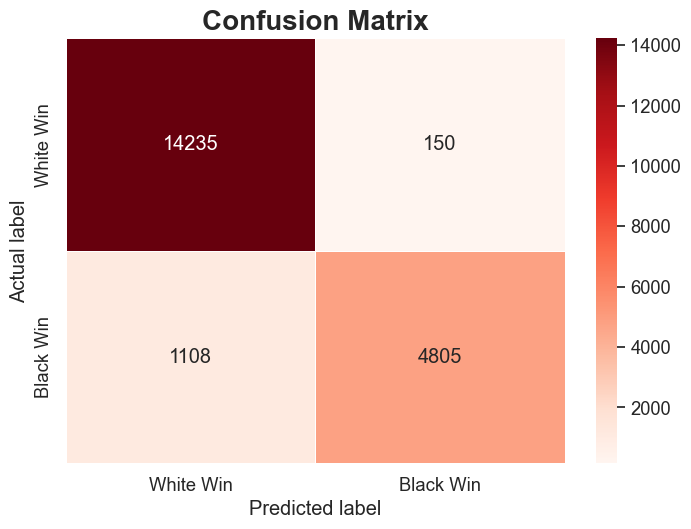

In [109]:
# Create a confusion matrix
confusion_matrix = np.array([[true_neg_0, false_pos_0],
                             [false_neg_0, true_pos_0]])

# Create a heatmap using Seaborn
class_names=['White Win','Black Win']
fig, ax = plt.subplots(figsize = (7,5))
sns.heatmap(confusion_matrix, 
            annot = True, 
            cmap = "Reds", 
            linecolor = 'white', 
            linewidth = .5, 
            fmt = 'g')
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)
plt.tight_layout()
plt.title('Confusion Matrix', size = 20, y = 1, weight = 'bold')
plt.ylabel('Actual label')
plt.xlabel('Predicted label');

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import classification_report

x_train = x_train.reshape(-1,1)
# Create a Logistic Regression model
logreg = LogisticRegression()

# Fit the model to your data
logreg.fit(x_train, y_train)

# Retrieve the coefficients (betas)
betas = logreg.coef_[0]
intercept = logreg.intercept_[0]
print("skelean = ", betas, intercept)

# generate classification report
print(classification_report(y_test, y_predict))

skelean =  [0.01002613] 0.41304165269734133
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      5913
           1       0.93      0.99      0.96     14385

    accuracy                           0.94     20298
   macro avg       0.95      0.90      0.92     20298
weighted avg       0.94      0.94      0.94     20298

